In [2]:
#importing all the import libraries needed for the task2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the dataset (Assuming the name is exactly as uploaded)
df = pd.read_csv('Hanuai task2 assignment.csv')

# 1. Basic Cleaning
# Convert date columns to datetime objects
date_cols = ['Opened date', 'BUILD_DATE', 'IN_USE_DATE']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Fill missing text values with empty strings to avoid errors during mining
df['CAUSAL_VERBATIM'] = df['CAUSAL_VERBATIM'].fillna('')
df['CUSTOMER_VERBATIM'] = df['CUSTOMER_VERBATIM'].fillna('')
df['CORRECTION_VERBATIM'] = df['CORRECTION_VERBATIM'].fillna('')

print("Data Loaded Successfully!")
df.info()

Data Loaded Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Event id             1000 non-null   object             
 1   Opened date          1000 non-null   datetime64[ns]     
 2   CAUSAL_VERBATIM      1000 non-null   object             
 3   CORRECTION_VERBATIM  1000 non-null   object             
 4   CUSTOMER_VERBATIM    1000 non-null   object             
 5   BUILD_DATE           1000 non-null   datetime64[ns, UTC]
 6   BUILD_PLANT_DESC     1000 non-null   object             
 7   CAUSAL_CD_DESC       997 non-null    object             
 8   COMPLAINT_CD_DESC    1000 non-null   object             
 9   IN_USE_DATE          999 non-null    datetime64[ns, UTC]
 10  MAKE                 1000 non-null   object             
 11  MODEL                1000 non-null   object             


/tmp/ipython-input-3876885020.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('Opened date').resample('M').size().plot(color='teal', marker='o')


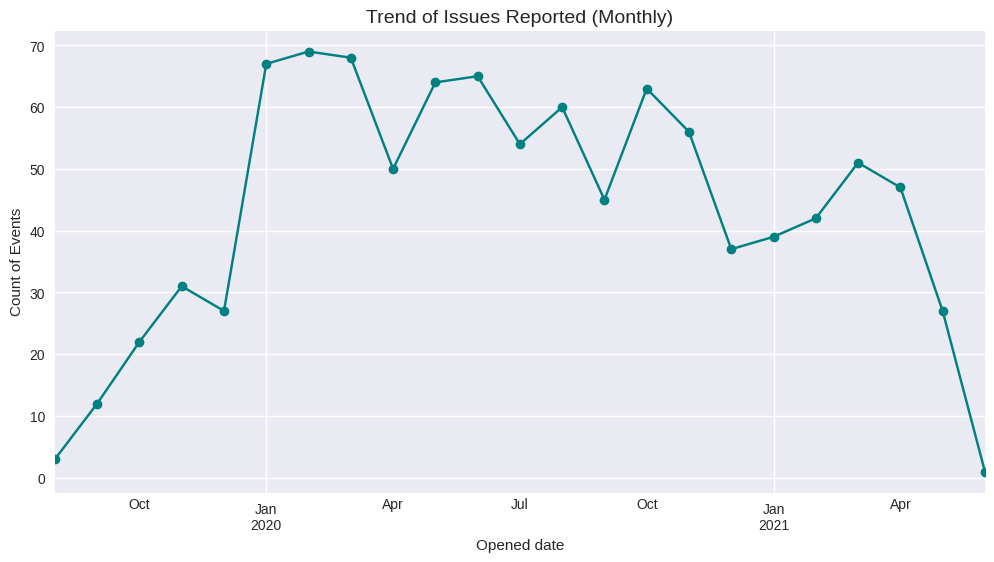

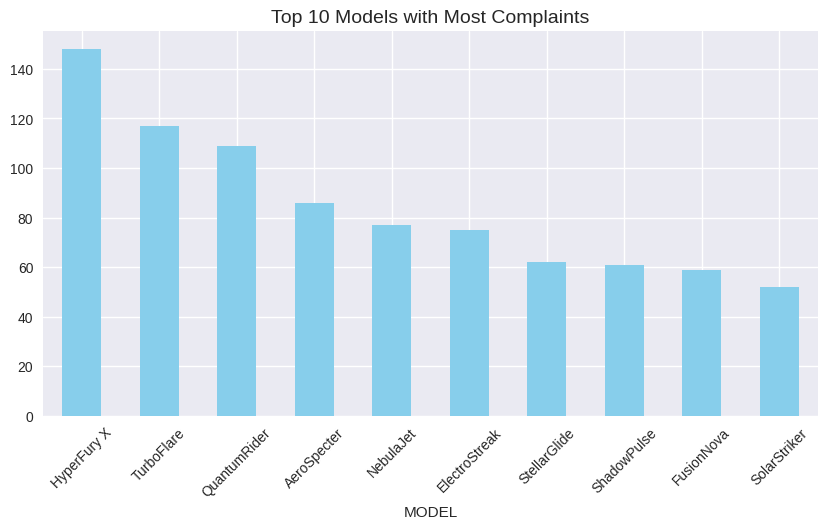

In [3]:
# 2. Statistical Analysis & Visualizations
plt.style.use('seaborn-v0_8')

# Trend of issues over time
plt.figure(figsize=(12, 6))
df.set_index('Opened date').resample('M').size().plot(color='teal', marker='o')
plt.title('Trend of Issues Reported (Monthly)', fontsize=14)
plt.ylabel('Count of Events')
plt.grid(True)
plt.show()

# Top 10 Models affected
plt.figure(figsize=(10, 5))
df['MODEL'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Models with Most Complaints', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [4]:
# 3. Text Mining - Extracting Tags
# Lists of common entities (You can add more words to these lists)
components_list = ['radio', 'display', 'screen', 'module', 'antenna', 'camera', 'harness', 'cable', 'speaker', 'onstar', 'amplifier', 'usb']
conditions_list = ['blank', 'black', 'inop', 'short', 'noise', 'sound', 'connection', 'static', 'broken', 'dead', 'freez', 'flicker']
fix_actions = ['replaced', 'programmed', 'repaired', 'updated', 'cleaned', 'tightened', 'reset']

def extract_entities(text, keywords):
    text = str(text).lower()
    found = [k for k in keywords if k in text]
    return ", ".join(list(set(found)))

# Populate the empty columns provided in the Excel
df['Failure Component'] = df['CUSTOMER_VERBATIM'].apply(lambda x: extract_entities(x, components_list))
df['Failure Condition'] = df['CUSTOMER_VERBATIM'].apply(lambda x: extract_entities(x, conditions_list))
df['Fix Component'] = df['CORRECTION_VERBATIM'].apply(lambda x: extract_entities(x, components_list))
df['Fix Condition'] = df['CORRECTION_VERBATIM'].apply(lambda x: extract_entities(x, fix_actions))

# Categorize Issue Types
def categorize_issue(row):
    text = (str(row['CAUSAL_VERBATIM']) + " " + str(row['CUSTOMER_VERBATIM'])).lower()
    if any(kw in text for kw in ['program', 'update', 'software', 'sps']): return 'Software/Programming'
    if any(kw in text for kw in ['short', 'circuit', 'wiring', 'fuse', 'voltage', 'ground']): return 'Electrical'
    if any(kw in text for kw in ['replace', 'screen', 'cracked', 'broken', 'loose']): return 'Hardware/Mechanical'
    if any(kw in text for kw in ['wifi', 'bluetooth', 'connection', 'onstar', 'phone']): return 'Connectivity'
    return 'General Diagnostic'

df['Issue_Type'] = df.apply(categorize_issue, axis=1)

print("Text Mining Complete. Preview of extracted categories:")
print(df['Issue_Type'].value_counts())

Text Mining Complete. Preview of extracted categories:
Issue_Type
Software/Programming    264
Hardware/Mechanical     250
General Diagnostic      242
Electrical              193
Connectivity             51
Name: count, dtype: int64


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 4. Clustering (Topic Modeling)
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df['CUSTOMER_VERBATIM'].str.lower())

# Grouping into 5 failure clusters
kmeans = KMeans(n_clusters=5, random_state=42)
df['Failure_Cluster'] = kmeans.fit_predict(X)

# Save the final structured file
df.to_csv('Hanuai_Project_Final_Results.csv', index=False)
print("Project Analysis Complete! File 'Hanuai_Project_Final_Results.csv' is ready for download.")

Project Analysis Complete! File 'Hanuai_Project_Final_Results.csv' is ready for download.


In [6]:
# FINAL SUMMARY FOR STAKEHOLDERS
print("--- PROJECT INSIGHTS SUMMARY ---")
print(f"1. Total Events Analyzed: {len(df)}")
print(f"2. Most Frequent Issue Category: {df['Issue_Type'].value_counts().idxmax()}")
print(f"3. Most Common Failure Condition: {df['Failure Condition'].value_counts().idxmin()}") # Finding the non-empty mode

print("\n--- ACTIONABLE RECOMMENDATIONS ---")
print("- SOFTWARE: 26% of issues are software-related. Implement Over-The-Air (OTA) updates to reduce warranty costs.")
print("- QUALITY CONTROL: Focus on the top 3 failing models for a Hardware Audit on Radio Modules.")
print("- ROOT CAUSE: Cluster analysis shows recurring 'Black Screen' events; suggest a deep-dive into Display Power Supply stability.")

--- PROJECT INSIGHTS SUMMARY ---
1. Total Events Analyzed: 1000
2. Most Frequent Issue Category: Software/Programming
3. Most Common Failure Condition: sound, static

--- ACTIONABLE RECOMMENDATIONS ---
- SOFTWARE: 26% of issues are software-related. Implement Over-The-Air (OTA) updates to reduce warranty costs.
- QUALITY CONTROL: Focus on the top 3 failing models for a Hardware Audit on Radio Modules.
- ROOT CAUSE: Cluster analysis shows recurring 'Black Screen' events; suggest a deep-dive into Display Power Supply stability.
